### COMP263 Final Project

#### Group 1 - Sec. 001

#### Developing an Intelligent Application that applies Deep Learning to solve real world problems

### Getting Dataset

We are using Research Paper Abstract dataset to train a model to classify abstract into different sections that make reading an abstract easier

In [1]:
!git clone https://github.com/franck-dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Using the 20k dataset
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" # Change path if not using google colab

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

### Preprocess Data

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

#Reading lines in the training dataset
train_lines = get_lines(data_dir + "train.txt")

#printing first 10 lines in training dataset
train_lines[:20] 
  

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Observations:
1. Each new record starts with ### 
2. RecordS contains BACKGROUND, METHODS, OBJECTIVE, RESULTS and CONCLUSIONS sections
3. Each section is followed by Text corresponding to the section
4. Numbers are represented by @

In [6]:
def preprocess_text_with_line_numbers(filename):

    """
    Preprocessing all records to get target (Section), text, line number and total lines
      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" 
    abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in file
    for line in input_lines:
      if line.startswith('###'):  # new abstract line is indicated by ###
        abstract_id = line
        abstract_lines = "" 
      elif line.isspace(): # new line
        abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them
        for abstract_line_number, abstract_lines in enumerate(abstract_line_split):
          line_data = {} # create empty dict to store data from line
          target_text_split = abstract_lines.split("\t") # split target label from text
          line_data['target'] = target_text_split[0] # get target label
          line_data['text'] = target_text_split[1].lower() #get target text and lower it
          line_data["line_number"] = abstract_line_number # abstract line number
          line_data["total_lines"] = len(abstract_line_split) - 1 #total number of lines in abstract
          abstract_samples.append(line_data) # add line data to abstract samples list
    
      else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
        abstract_lines += line
  
    return abstract_samples


Applying preprocessing functions to the data files for train, test and dev

In [7]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
dev_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")

In [8]:
# printing samples in training data
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Converting dictionaries for train, test and dev to dataframe

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
dev_df = pd.DataFrame(dev_samples)
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [10]:
#Distribution of label 
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Histogram for total number of lines in train_df

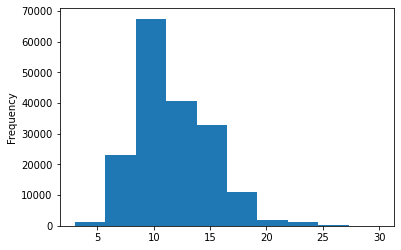

In [11]:
train_df.total_lines.plot.hist()

Extracting text into lists - Used as features for model

In [12]:
# Convert text lines into lists 
train_sentences = train_df["text"].tolist()
dev_sentences = dev_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(dev_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
#One Hot Encode Labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot =  one_hot_encoder.transform(dev_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot =  one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [14]:
# Label encode 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(dev_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())


## Baseline Model - MultinomialNB

We first developed a baseline model to evaluate the performance and to compare against all future models

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
base = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB() )
]) 

# Fit the pipeline to the training data
base.fit(X= train_sentences,
            y= train_labels_encoded); #one hot encoded labels might gives an error here

In [16]:
# Evaluate baseline on validation dataset
base.score(X=dev_sentences, y=val_labels_encoded)

0.7218323844829869

In [17]:
# Make predictions
baseline_preds = base.predict(dev_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

Model Evaluation on Validation Data

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
baseline_accuracy = accuracy_score(baseline_preds,val_labels_encoded )
print("Model accuracy score is: ", accuracy_score(baseline_preds,val_labels_encoded ))
print("Model precision is:", precision_score(baseline_preds, val_labels_encoded,average='weighted'))
print("Model recall score is:", recall_score(baseline_preds, val_labels_encoded,average='weighted'))
print("Model f1 score is:", f1_score(baseline_preds, val_labels_encoded,average='weighted'))

Model accuracy score is:  0.7218323844829869
Model precision is: 0.7835634520695112
Model recall score is: 0.7218323844829869
Model f1 score is: 0.7447397336209445


### Data Preparation for Deep Sequence Models

In [19]:
#imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Checking the average length of each sentence and plotting it

26.338269273494777


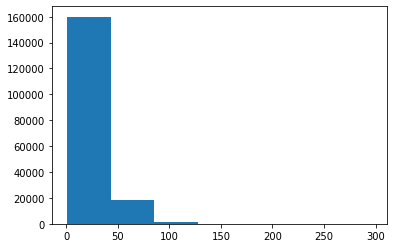

In [20]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
print(avg_sent_len)

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

Evaluating the length of 95% of sentences. This will be used as the max length for sentences when training the model as we want all sentences to be of same length.

In [21]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

So the length of sentences will be 55. We will truncate sentences with length greater than 55 and pad sentences with 0 that are less than 55.

### Text Vectorizer

In [22]:
#maximum words in the vocabulary in our dataset is 68000
max_tokens = 68000

In [23]:
# Create text vectorizer to convert text into numbers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) 

In [24]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

### Text Embedding

In [25]:
#printing vocabulary in our dataset
vocabulary = text_vectorizer.get_vocabulary()
vocabulary[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

We need text embedding to learn relationship between tokens in our data

In [26]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(vocabulary), # length of vocabulary
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding") 

### Create Dataset using TF Datasets

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [28]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Supervised Learning Model : Conv1D with token embeddings

In [29]:
num_classes = len(label_encoder.classes_)

# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

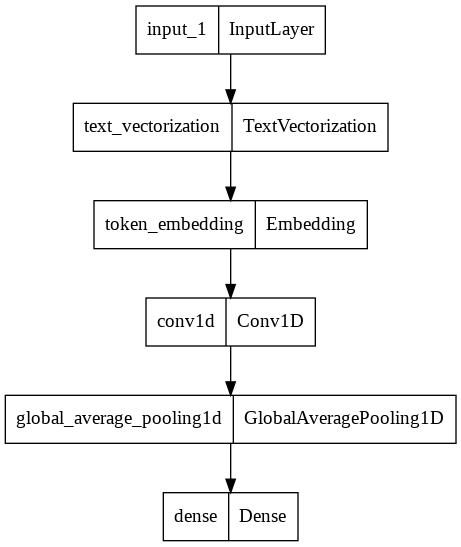

In [85]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_1)

In [31]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10 % of batches

Epoch 1/3
562/562 [==============================] - 13s 9ms/step - loss: 0.9143 - accuracy: 0.6366 - val_loss: 0.6828 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6551 - accuracy: 0.7590 - val_loss: 0.6285 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6155 - accuracy: 0.7762 - val_loss: 0.5931 - val_accuracy: 0.7849


In [32]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5948 - accuracy: 0.7872


[0.5947542190551758, 0.7872037887573242]

In [33]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.40070182e-01, 1.63085461e-01, 7.81173706e-02, 2.95771658e-01,
        2.29552984e-02],
       [4.49085921e-01, 2.76157796e-01, 1.36935636e-02, 2.53466338e-01,
        7.59646529e-03],
       [1.29154086e-01, 6.92016259e-03, 1.31837407e-03, 8.62572134e-01,
        3.53162905e-05],
       ...,
       [5.30602665e-06, 6.95410476e-04, 6.55095442e-04, 2.97165207e-06,
        9.98641193e-01],
       [5.43765239e-02, 4.45692956e-01, 1.05319396e-01, 7.37455860e-02,
        3.20865571e-01],
       [1.80634767e-01, 6.87856436e-01, 3.83860916e-02, 4.34259325e-02,
        4.96968180e-02]], dtype=float32)

In [34]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
supervised_accuracy = accuracy_score(model_1_preds,val_labels_encoded )
print("Model accuracy score is: ", accuracy_score(model_1_preds,val_labels_encoded ))
print("Model precision is:", precision_score(model_1_preds, val_labels_encoded,average='weighted'))
print("Model recall score is:", recall_score(model_1_preds, val_labels_encoded,average='weighted'))
print("Model recall score is:", f1_score(model_1_preds, val_labels_encoded,average='weighted'))

Model accuracy score is:  0.7872037600953263
Model precision is: 0.7932587281156172
Model recall score is: 0.7872037600953263
Model recall score is: 0.7895222547395402


## Unsupervised Learning Model: Feature extraction with pretrained token embedding

In [36]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Example of how the token embeddings are generated

In [37]:
import random
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}")
     

Random training sentence:
this study sought to determine whether the therapeutic effect of culture-expanded mscs persists , even in older subjects .

Sentence after embedding:
[ 0.08771987  0.05939453  0.02172423 -0.07406136 -0.05045867  0.00359523
  0.04630664 -0.05142814  0.04956292  0.04558969  0.07811201  0.04887781
  0.08742398  0.05943971 -0.02412589 -0.06166443 -0.0981058   0.02083079
  0.00411217 -0.09232771  0.04852819  0.03779484 -0.04508897 -0.02837089
 -0.02067846  0.00766729  0.00455784 -0.0663647   0.07848673  0.04660413]


Using the pretrained token embedding for feature extraction and using in a model

In [38]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


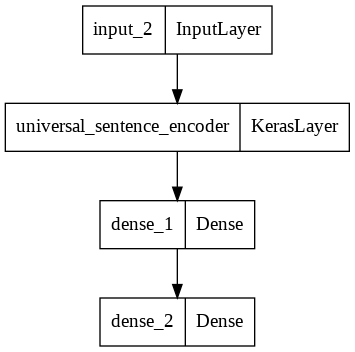

In [86]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_2)

In [40]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9136 - accuracy: 0.6512 - val_loss: 0.7955 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7692 - accuracy: 0.7014 - val_loss: 0.7532 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7514 - accuracy: 0.7132 - val_loss: 0.7377 - val_accuracy: 0.7094


In [41]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7408 - accuracy: 0.7135


[0.7408347725868225, 0.713458240032196]

In [42]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.4637612e-01, 3.3900574e-01, 2.7625556e-03, 2.0081307e-01,
        1.1042452e-02],
       [3.3929706e-01, 5.2300078e-01, 4.5179399e-03, 1.2992653e-01,
        3.2576404e-03],
       [2.1303570e-01, 1.4485313e-01, 1.9346014e-02, 5.8261544e-01,
        4.0149678e-02],
       ...,
       [1.5132619e-03, 6.4003542e-03, 4.5649067e-02, 7.6035230e-04,
        9.4567698e-01],
       [3.2949706e-03, 5.1577572e-02, 1.9588700e-01, 1.0922817e-03,
        7.4814814e-01],
       [1.8220849e-01, 2.3575027e-01, 5.1659203e-01, 4.6665194e-03,
        6.0782697e-02]], dtype=float32)

In [43]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [44]:
unsupervised_accuracy = accuracy_score(model_2_preds,val_labels_encoded )
print("Model accuracy score is: ", accuracy_score(model_2_preds,val_labels_encoded ))
print("Model precision is:", precision_score(model_2_preds, val_labels_encoded,average='weighted'))
print("Model recall score is:", recall_score(model_2_preds, val_labels_encoded,average='weighted'))
print("Model f1 score score is:", f1_score(model_2_preds, val_labels_encoded,average='weighted'))

Model accuracy score is:  0.7134582285184695
Model precision is: 0.7247347175835855
Model recall score is: 0.7134582285184695
Model f1 score score is: 0.7164495272928634


## State of the art Model - Pretrained Model + Char Embedding + Positional embedding

Create Char Embedding


In [45]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h i s   s t u d y   s o u g h t   t o   d e t e r m i n e   w h e t h e r   t h e   t h e r a p e u t i c   e f f e c t   o f   c u l t u r e - e x p a n d e d   m s c s   p e r s i s t s   ,   e v e n   i n   o l d e r   s u b j e c t s   .'

In [46]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in dev_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [47]:
#avergae char length
import numpy as np
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

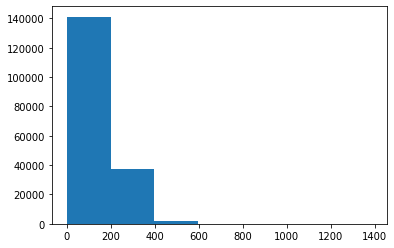

In [48]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins =7)

In [49]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [50]:
# Get all keyboard characters for char-level embedding
import string
alphabet =  string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKEN = len(alphabet) + 2 #num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name = "char_vectorizer")
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [52]:
# Check character vocabulary
char_vocab = char_vectorizer.get_vocabulary()
print("Length of char vocabulary", len(char_vocab))
char_vocab[:10]

Length of char vocabulary 28


['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']

In [53]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKEN,  # number of different characters
                              output_dim = 25,# embedding dimension of each character
                              mask_zero = False, 
                              name = "char_embed")

Create Positional Embedding

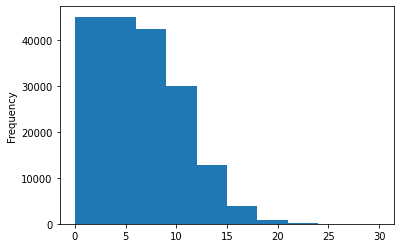

In [54]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()


In [55]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(dev_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [56]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

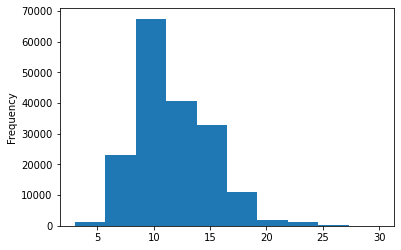

In [57]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [58]:
# Check the coverage of a "total_lines" for 98% of samples
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [59]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(dev_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

Embedding Model

In [60]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = "string", name = "token_inputs")
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embedding)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs) 
# 2. Char inputs
char_inputs = layers.Input(shape = [], dtype = "string", name = "char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers. Bidirectional(layers.LSTM(32))(char_embedding)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape = (15, ), dtype = tf.int32, name = "line_number_inputs" )
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.int32, name = "total_lines_input")
x = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = x)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output,
                                                                                char_model.output])
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name = "token_char_positional_embedding")([line_number_model.output,
                                                                  total_lines_model.output,
                                                                  z])

# 7. Create output layer
output_layer = layers.Dense(5, activation = "softmax", name="output_layer")(z)

# 8. Put together model
model_3 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                                   outputs = output_layer 
                                   )

In [61]:
model_3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

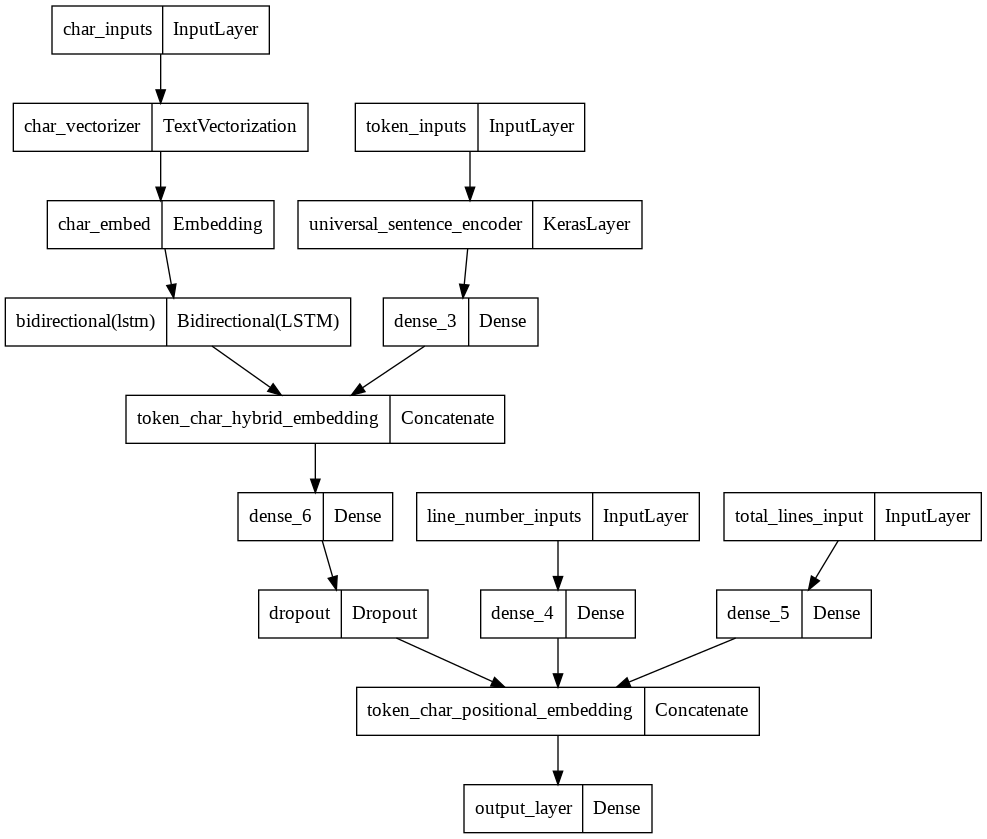

In [62]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_3)

In [63]:
# Compile token, char, positional embedding model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Dataset for the Model before Fitting

In [64]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              dev_sentences,
                                                              valid_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [65]:
# Fit the token, char and positional embedding model
history_model_3 = model_3.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 36ms/step - loss: 1.0975 - accuracy: 0.7200 - val_loss: 0.9872 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9692 - accuracy: 0.8131 - val_loss: 0.9534 - val_accuracy: 0.8221
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9513 - accuracy: 0.8217 - val_loss: 0.9408 - val_accuracy: 0.8278


In [66]:
# Make predictions with state of the art model
model_3_pred_probs = model_3.predict(val_pos_char_token_dataset, verbose=1)
model_3_pred_probs

945/945 [==============================] - 25s 26ms/step


array([[0.51134515, 0.10708278, 0.01255352, 0.35169908, 0.01731951],
       [0.5445091 , 0.10357472, 0.052452  , 0.28968495, 0.00977922],
       [0.3105027 , 0.12174153, 0.1612712 , 0.33442023, 0.07206434],
       ...,
       [0.03118496, 0.09720077, 0.04642772, 0.03024249, 0.79494405],
       [0.02946912, 0.3060946 , 0.09037012, 0.0255505 , 0.54851574],
       [0.28598705, 0.48524928, 0.11384756, 0.04974462, 0.06517144]],
      dtype=float32)

In [67]:
# Turn prediction probabilities into prediction classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds
     

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [68]:
# Calculate results of state of the art model
state_of_art_acc = accuracy_score(model_3_preds,val_labels_encoded )
print("Model accuracy score is: ", accuracy_score(model_3_preds,val_labels_encoded ))
print("Model precision is:", precision_score(model_3_preds, val_labels_encoded,average='weighted'))
print("Model recall score is:", recall_score(model_3_preds, val_labels_encoded,average='weighted'))
print("Model recall score is:", f1_score(model_3_preds, val_labels_encoded,average='weighted'))

Model accuracy score is:  0.8310605057593009
Model precision is: 0.8350599893601844
Model recall score is: 0.8310605057593009
Model recall score is: 0.832388529046301


## Compare Model Results

In [69]:
all_model_results = pd.DataFrame([{"Baseline Model": baseline_accuracy,
                                  "Supervised Learning Model": supervised_accuracy,
                                  "Unsupervised Learning_model": unsupervised_accuracy,
                                  "State of the Art model": state_of_art_acc}])
all_model_results = all_model_results.transpose()
all_model_results

,0
Baseline Model,0.721832
Supervised Learning Model,0.787204
Unsupervised Learning_model,0.713458
State of the Art model,0.831061


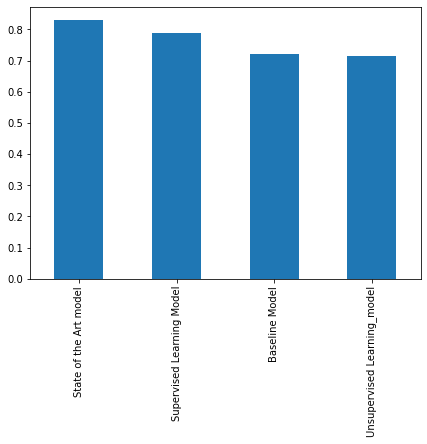

In [70]:
# Sort model results by accuracy score
all_model_results.sort_values(0, ascending=False)[0].plot(kind="bar", figsize=(7, 5));

We can observe that the State of the art model which uses Pretrained model +char embedding + Positional embedding is giving us the best results

## Evaluate model on test Dataset

In [71]:
#Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [72]:
# Make predictions on the test dataset
test_pred_probs = model_3.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 20s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [73]:
#Evaluating model on test set
print("Model accuracy score is: ", accuracy_score(test_preds, test_labels_encoded ))
print("Model precision is:", precision_score(test_preds, test_labels_encoded,average='weighted'))
print("Model recall score is:", recall_score(test_preds, test_labels_encoded,average='weighted'))
print("Model f1 score is:", f1_score(test_preds, test_labels_encoded,average='weighted'))

Model accuracy score is:  0.8275427244068359
Model precision is: 0.8313375097997303
Model recall score is: 0.8275427244068359
Model f1 score is: 0.8288458898830442


## Make predictions on sample abstract

In [74]:
example_abstract = {'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'}

In [75]:
#example_abstract = {'abstract': 'Sentence classification is extremely useful for several use cases such as document classification, spam filtering, and sentiment analysis. Existing models for sentence classification that use neural networks do not take into account the context in which they appear. However, even without the context, these models are useful for tasks such as providing semantic headings to unstructured text. In this paper, we describe the experiments performed to develop an architecture for sentence classification using natural language processing and deep sequence modeling. Our model reaches an optimal performance by leveraging a state-of-the-art model for generating text embeddings.'}

In [76]:
# Create sentencizer 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstract["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] #lines in abstract
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [77]:
# Get total number of lines
total_lines = len(abstract_lines)

# Go through each line in abstract and create features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [78]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [79]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot


<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [80]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [81]:
test_abstract_pred_probs = model_3.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step


array([[0.26864564, 0.09948669, 0.01517582, 0.5922619 , 0.0244299 ],
       [0.07610748, 0.02817903, 0.7032617 , 0.10219631, 0.09025551],
       [0.14353423, 0.05358532, 0.5269044 , 0.19337052, 0.08260553],
       [0.13034919, 0.18541946, 0.4676656 , 0.09084632, 0.12571934],
       [0.05001524, 0.09146379, 0.39802533, 0.05303608, 0.40745956],
       [0.0402042 , 0.13086237, 0.5034652 , 0.04717693, 0.2782913 ],
       [0.02574667, 0.11645993, 0.0982163 , 0.02772008, 0.731857  ],
       [0.01969424, 0.12997557, 0.2649676 , 0.03024042, 0.55512214]],
      dtype=float32)

In [82]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [83]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [84]:
# Printing Class and Abstract lines
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
